#FRED-Net (Predicting Economic Indicators with Recurrent Neural Networks)

# Libraries and Dependencies

In [ ]:
pip install fredapi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install u8darts[all] 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from os import name, path
from fredapi import Fred
import os
fred = Fred(api_key='795348edc3b0f46479b0ecba8cd33c70')
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
from scipy.stats import variation
%matplotlib inline
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")
import sklearn
from sklearn.metrics import mean_squared_error
import datetime
import matplotlib.dates as mdates
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM,GRU
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler


# Data Collection and API

In [ ]:
search_key=''
obs_start=''
obs_end=''
series=''
search_key=input("Enter the financial term for which you want to predict the near future :")
search_result=fred.search(search_key)
metadata =pd.DataFrame(search_result)
metadata

Enter the financial term for which you want to predict the near future :gdp


,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
GFDEGDQ188S,GFDEGDQ188S,2023-04-05,2023-04-05,Federal Debt: Total Public Debt as Percent of ...,1966-01-01,2022-10-01,Quarterly,Q,Percent of GDP,% of GDP,Seasonally Adjusted,SA,2023-03-30 08:05:01-05:00,83,Federal Debt: Total Public Debt as Percent of ...
FYFSGDA188S,FYFSGDA188S,2023-04-05,2023-04-05,Federal Surplus or Deficit [-] as Percent of G...,1929-01-01,2022-01-01,Annual,A,Percent of GDP,% of GDP,Not Seasonally Adjusted,NSA,2023-03-30 08:05:04-05:00,71,Federal Surplus or Deficit [-] as Percent of G...
FYFSDFYGDP,FYFSDFYGDP,2023-04-05,2023-04-05,Federal Surplus or Deficit [-] as Percent of G...,1930-06-30,2022-09-30,"Annual, Fiscal Year",A,Percent of GDP,% of GDP,Not Seasonally Adjusted,NSA,2023-03-15 13:55:01-05:00,29,None
GDP,GDP,2023-04-05,2023-04-05,Gross Domestic Product,1947-01-01,2022-10-01,Quarterly,Q,Billions of Dollars,Bil. of $,Seasonally Adjusted Annual Rate,SAAR,2023-03-30 07:55:01-05:00,92,BEA Account Code: A191RC Gross domestic produ...
FYONGDA188S,FYONGDA188S,2023-04-05,2023-04-05,Federal Net Outlays as Percent of Gross Domest...,1929-01-01,2022-01-01,Annual,A,Percent of GDP,% of GDP,Not Seasonally Adjusted,NSA,2023-03-30 08:05:05-05:00,63,Federal Net Outlays as Percent of Gross Domest...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VAPGDPW,VAPGDPW,2023-04-05,2023-04-05,Value Added by Industry: Wholesale Trade as a ...,2005-01-01,2022-10-01,Quarterly,Q,Percent,%,Not Seasonally Adjusted,NSA,2023-03-30 07:38:12-05:00,12,Value added represents the sum of the costs-in...
RGDPNAETA666NRUG,RGDPNAETA666NRUG,2023-04-05,2023-04-05,Real GDP at Constant National Prices for Ethiopia,1950-01-01,2019-01-01,Annual,A,Millions of 2017 U.S. Dollars,Mil. of 2017 U.S. $,Not Seasonally Adjusted,NSA,2021-11-08 13:29:10-06:00,12,Source ID: rgdpna When using these data in yo...
USALORSGPTDSTSAM,USALORSGPTDSTSAM,2023-04-05,2023-04-05,Leading Indicators OECD: Reference series: Gro...,1960-01-01,2022-11-01,Monthly,M,Index,Index,Seasonally Adjusted,SA,2023-03-15 13:06:08-05:00,12,OECD descriptor ID: LORSGPTD OECD unit ID: STS...


In [ ]:
series=input("Enter the series id from the above result :")
if series in metadata['id']:
  obs_start=metadata[metadata.id==series]['observation_start'].tolist()
  obs_end=metadata[metadata.id==series]['observation_end'].tolist()
  data= fred.get_series(series , observation_start=obs_start[0] , observation_end=obs_end[0])
  finaldata=pd.DataFrame(data)
else:
  print('Enter valid series')

Enter the series id from the above result :GDP


In [ ]:
finaldata.columns=['Values']


In [ ]:
finaldata_ml=finaldata.copy()
finaldata_ml

,Values
1947-01-01,243.164
1947-04-01,245.968
1947-07-01,249.585
1947-10-01,259.745
1948-01-01,265.742
...,...
2021-10-01,24349.121
2022-01-01,24740.480
2022-04-01,25248.476
2022-07-01,25723.941


# Analysing the custom Time-Series

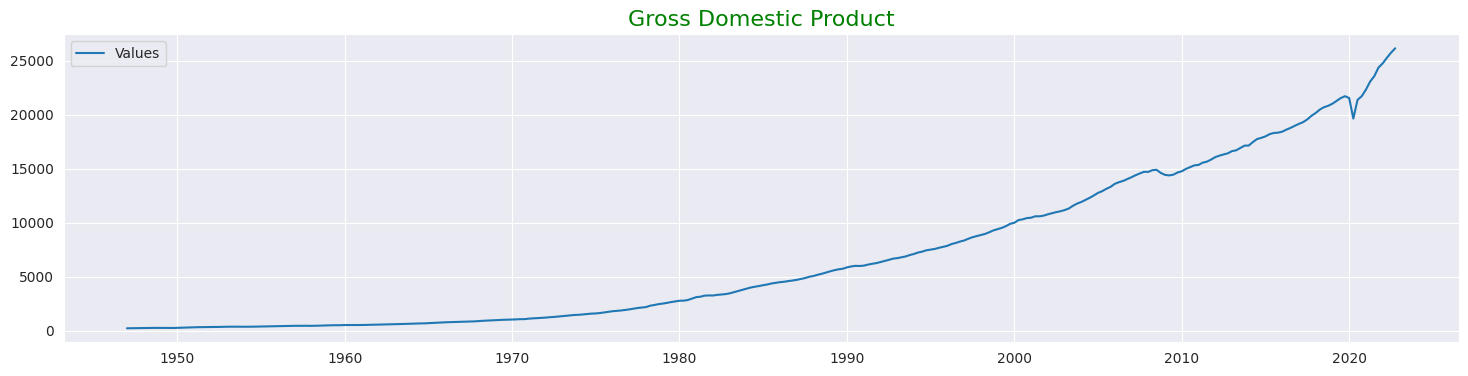

In [ ]:
plt.figure(figsize=(18,4))
plt.plot(finaldata_ml.Values, label='Values')
plt.legend(loc='best')
plt.title(metadata[metadata.id==series]['title'][0], fontdict={'fontsize': 16, 'fontweight' : 5, 'color' : 'Green'})
#xticks = pd.date_range(min(finaldata.Time),max(finaldata.Time), freq='Q')
# default_x_ticks = range(len(finaldata.Time))
# plt.plot(default_x_ticks, finaldata.Time)
# plt.xticks(default_x_ticks, finaldata.Values)
plt.show()

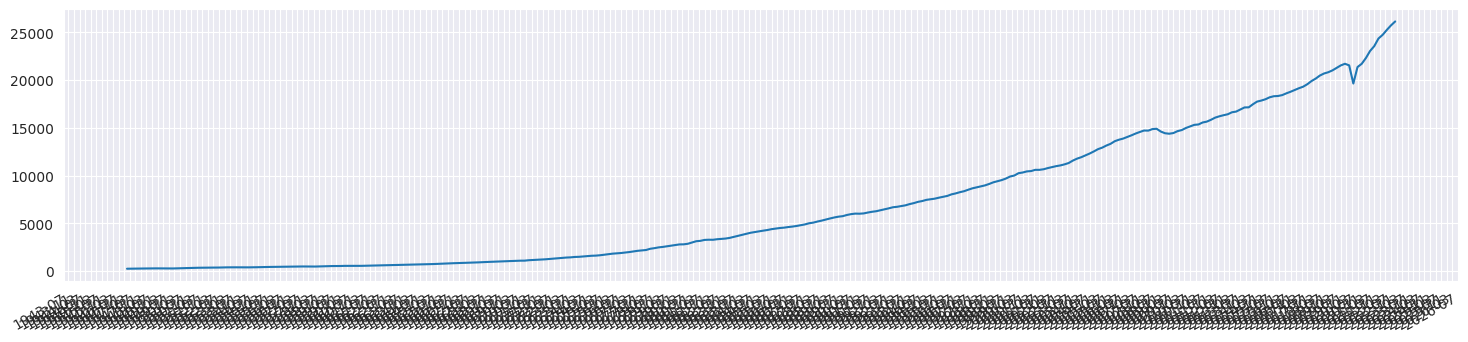

In [ ]:
fig, ax = plt.subplots(figsize=(18,4))

# Same as above
if metadata[metadata.id==series]['frequency_short'][0] == 'Q':
  half_year_locator = mdates.MonthLocator(interval=4)
  year_month_formatter = mdates.DateFormatter("%Y-%m")
  ax.xaxis.set_major_locator(half_year_locator)
  ax.xaxis.set_major_formatter(year_month_formatter)
  ax.plot(finaldata.Values)
elif metadata[metadata.id==series]['frequency_short'][0] == 'A':
  half_year_locator = mdates.MonthLocator(interval=12)
  year_month_formatter = mdates.DateFormatter("%Y-%m")
  ax.xaxis.set_major_locator(half_year_locator)
  ax.xaxis.set_major_formatter(year_month_formatter)
  ax.plot(finaldata.Values)
# Rotates and right aligns the x labels. 
# Also moves the bottom of the axes up to make room for them.
fig.autofmt_xdate()

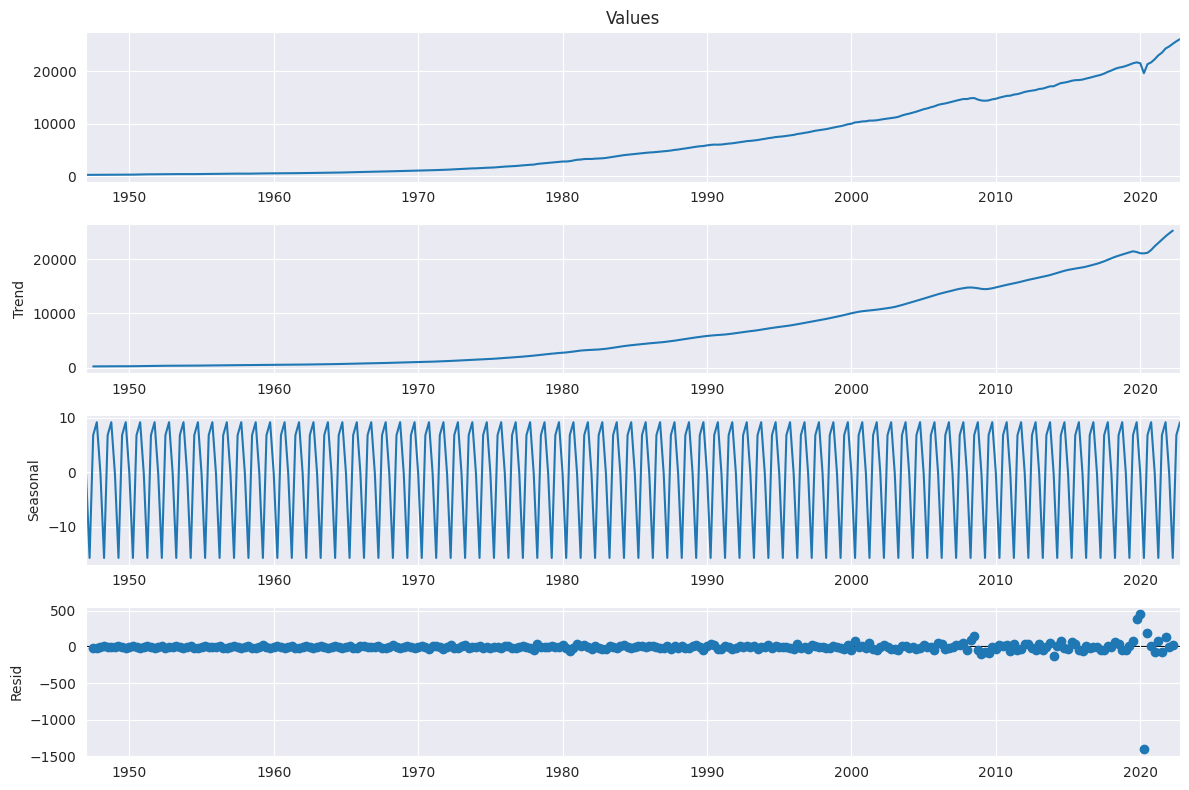

In [ ]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 12, 8
if metadata[metadata.id==series]['frequency_short'][0] == 'Q':
  decomposition = sm.tsa.seasonal_decompose(finaldata.Values, model='additive',period=4) # additive seasonal index
  fig = decomposition.plot()
  plt.show()
elif metadata[metadata.id==series]['frequency_short'][0] == 'A':
  decomposition = sm.tsa.seasonal_decompose(finaldata.Values, model='additive',period=12) # additive seasonal index
  fig = decomposition.plot()

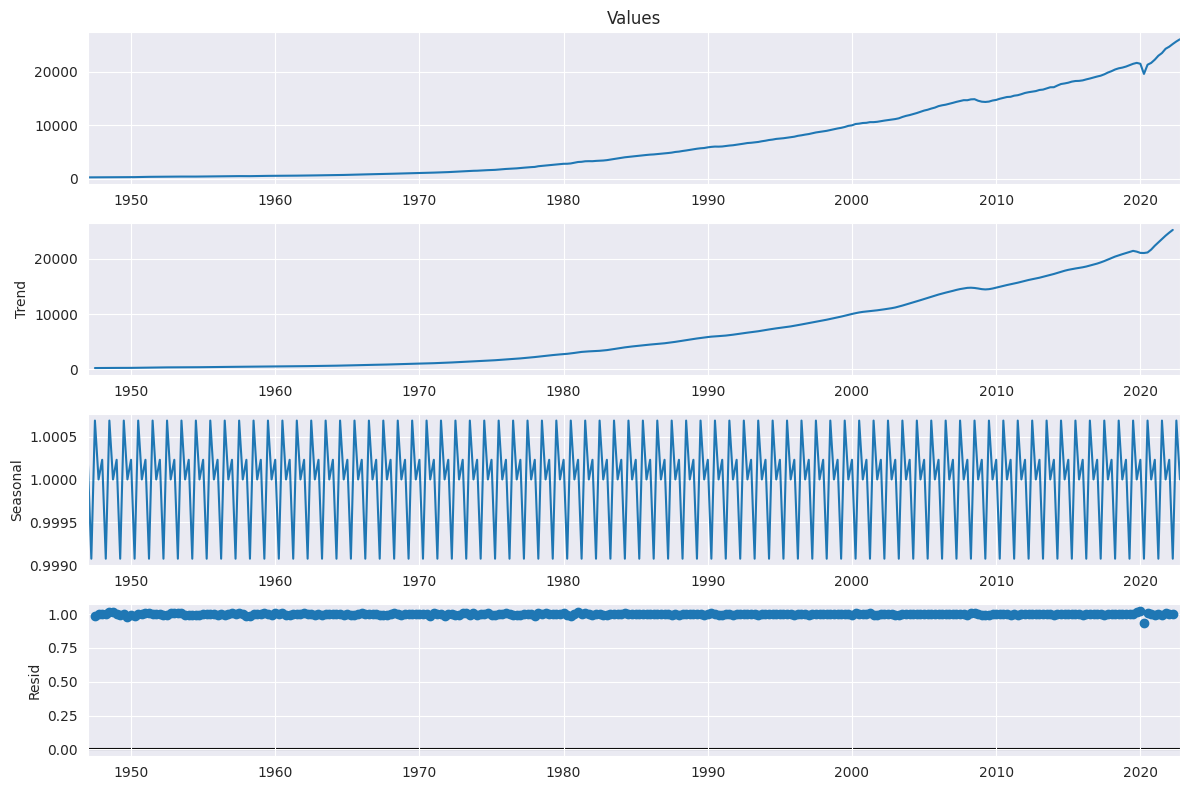

In [ ]:
if metadata[metadata.id==series]['frequency_short'][0] == 'Q':
  decomposition = sm.tsa.seasonal_decompose(finaldata.Values, model='multiplicative',period=4) # multiplicative seasonal index
  fig = decomposition.plot()
  plt.show()
elif metadata[metadata.id==series]['frequency_short'][0] == 'A':
  decomposition = sm.tsa.seasonal_decompose(finaldata.Values, model='multiplicative',period=12) # multiplicativeSeasonal index
  fig = decomposition.plot()


# Train-Test Split for ML methods

In [ ]:
train_len=round(70*(len(finaldata_ml.Values))/100)

train=finaldata_ml[0:train_len]
test=finaldata_ml[train_len : ]
train.head()

,Values
1947-01-01,243.164
1947-04-01,245.968
1947-07-01,249.585
1947-10-01,259.745
1948-01-01,265.742


In [ ]:
test

,Values
2000-04-01,10247.720
2000-07-01,10318.165
2000-10-01,10435.744
2001-01-01,10470.231
2001-04-01,10599.000
...,...
2021-10-01,24349.121
2022-01-01,24740.480
2022-04-01,25248.476
2022-07-01,25723.941


# Naive Forecast

In [ ]:
y_hat_naive = test.copy()
y_hat_naive['naive_forecast'] = train['Values'][train_len-1]
y_hat_naive

,Values,naive_forecast
2000-04-01,10247.720,10002.179
2000-07-01,10318.165,10002.179
2000-10-01,10435.744,10002.179
2001-01-01,10470.231,10002.179
2001-04-01,10599.000,10002.179
...,...,...
2021-10-01,24349.121,10002.179
2022-01-01,24740.480,10002.179
2022-04-01,25248.476,10002.179
2022-07-01,25723.941,10002.179


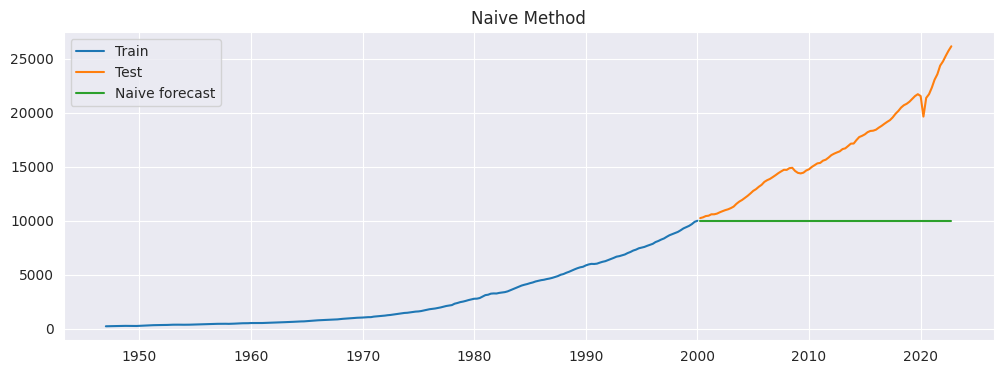

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(train['Values'], label='Train')
plt.plot(test['Values'], label='Test')
plt.plot(y_hat_naive['naive_forecast'], label='Naive forecast')
plt.legend(loc='best')
plt.title('Naive Method')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Values'], y_hat_naive['naive_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Values']-y_hat_naive['naive_forecast'])/test['Values'])*100,2)

results = pd.DataFrame({'Method':['Naive method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,7583.4,35.09


# Average Forecast

In [ ]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Values'].mean()
y_hat_avg

,Values,avg_forecast
2000-04-01,10247.720,2806.712789
2000-07-01,10318.165,2806.712789
2000-10-01,10435.744,2806.712789
2001-01-01,10470.231,2806.712789
2001-04-01,10599.000,2806.712789
...,...,...
2021-10-01,24349.121,2806.712789
2022-01-01,24740.480,2806.712789
2022-04-01,25248.476,2806.712789
2022-07-01,25723.941,2806.712789


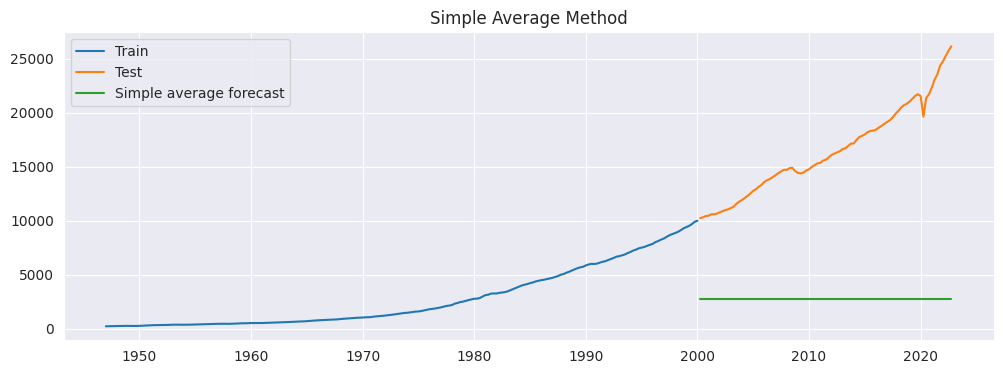

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(train['Values'], label='Train')
plt.plot(test['Values'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Simple average forecast')
plt.legend(loc='best')
plt.title('Simple Average Method')
plt.show()

In [ ]:
rmse = np.sqrt(mean_squared_error(test['Values'], y_hat_avg['avg_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Values']-y_hat_avg['avg_forecast'])/test['Values'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple average method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,7583.40,35.09
0,Simple average method,14186.32,81.79


# Simple Moving Average

In [ ]:
y_hat_sma1 = finaldata.copy()
ma_window = 4
y_hat_sma1['sma_forecast'] = finaldata['Values'].rolling(ma_window).mean()
y_hat_sma1['sma_forecast'][train_len:] = y_hat_sma1['sma_forecast'][train_len-1]
y_hat_sma1

,Values,sma_forecast
1947-01-01,243.164,NaN
1947-04-01,245.968,NaN
1947-07-01,249.585,NaN
1947-10-01,259.745,249.6155
1948-01-01,265.742,255.2600
...,...,...
2021-10-01,24349.121,9778.7960
2022-01-01,24740.480,9778.7960
2022-04-01,25248.476,9778.7960
2022-07-01,25723.941,9778.7960


In [ ]:
y_hat_sma = finaldata.copy()
ma_window = 12
y_hat_sma['sma_forecast'] = finaldata['Values'].rolling(ma_window).mean()
y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len-1]
y_hat_sma

,Values,sma_forecast
1947-01-01,243.164,NaN
1947-04-01,245.968,NaN
1947-07-01,249.585,NaN
1947-10-01,259.745,NaN
1948-01-01,265.742,NaN
...,...,...
2021-10-01,24349.121,9227.140667
2022-01-01,24740.480,9227.140667
2022-04-01,25248.476,9227.140667
2022-07-01,25723.941,9227.140667


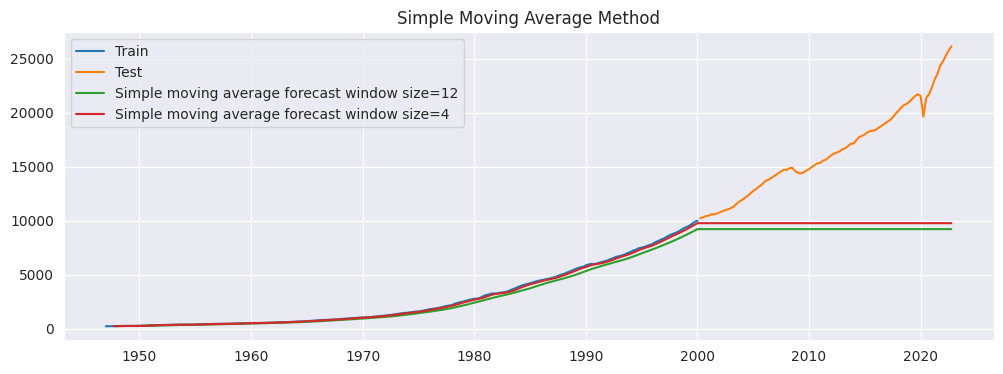

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(train['Values'], label='Train')
plt.plot(test['Values'], label='Test')
plt.plot(y_hat_sma['sma_forecast'], label='Simple moving average forecast window size=12')
plt.plot(y_hat_sma1['sma_forecast'], label='Simple moving average forecast window size=4')
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

In [ ]:
rmse1 = np.sqrt(mean_squared_error(test['Values'], y_hat_sma1['sma_forecast'][train_len:])).round(2)
mape1 = np.round(np.mean(np.abs(test['Values']-y_hat_sma1['sma_forecast'][train_len:])/test['Values'])*100,2)

rmse = np.sqrt(mean_squared_error(test['Values'], y_hat_sma['sma_forecast'][train_len:])).round(2)
mape = np.round(np.mean(np.abs(test['Values']-y_hat_sma['sma_forecast'][train_len:])/test['Values'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple moving average forecast window size=4','Simple moving average forecast window size=12'], 'RMSE': [rmse1,rmse],'MAPE': [mape1,mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results


,Method,RMSE,MAPE
0,Naive method,7583.40,35.09
0,Simple average method,14186.32,81.79
0,Simple moving average forecast window size=4,7772.59,36.54
1,Simple moving average forecast window size=12,8247.11,40.12


# Simple Exponential Smoothing

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model = SimpleExpSmoothing(train['Values'])
model_fit = model.fit(optimized=True)
model_fit.params
y_hat_ses = test.copy()
y_hat_ses['ses_forecast'] = model_fit.forecast(len(test))
y_hat_ses

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


,Values,ses_forecast
2000-04-01,10247.720,10001.663591
2000-07-01,10318.165,10001.663591
2000-10-01,10435.744,10001.663591
2001-01-01,10470.231,10001.663591
2001-04-01,10599.000,10001.663591
...,...,...
2021-10-01,24349.121,10001.663591
2022-01-01,24740.480,10001.663591
2022-04-01,25248.476,10001.663591
2022-07-01,25723.941,10001.663591


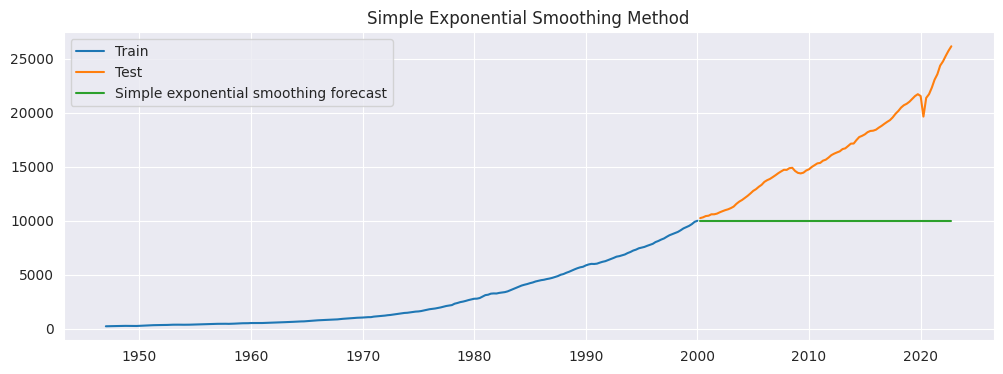

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(train['Values'], label='Train')
plt.plot(test['Values'], label='Test')
plt.plot(y_hat_ses['ses_forecast'], label='Simple exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing Method')
plt.show()

In [ ]:
rmse = np.sqrt(mean_squared_error(test['Values'], y_hat_ses['ses_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Values']-y_hat_ses['ses_forecast'])/test['Values'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple exponential smoothing forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

,Method,RMSE,MAPE
0,Naive method,7583.40,35.09
0,Simple average method,14186.32,81.79
0,Simple moving average forecast window size=4,7772.59,36.54
1,Simple moving average forecast window size=12,8247.11,40.12
0,Simple exponential smoothing forecast,7583.84,35.10


# Holt's Forecast

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model1 = ExponentialSmoothing(np.asarray(train['Values']) ,seasonal_periods=4 ,trend='additive', seasonal=None)
model_fit1 = model1.fit(optimized=True)
print(model_fit1.params)
y_hat_holt1 = test.copy()
y_hat_holt1['holt_forecast'] = model_fit1.forecast(len(test))
y_hat_holt1



{'smoothing_level': 0.995, 'smoothing_trend': 0.2132142857142857, 'smoothing_seasonal': nan, 'damping_trend': nan, 'initial_level': 241.7308666666666, 'initial_trend': 4.098351515151528, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


,Values,holt_forecast
2000-04-01,10247.720,10142.605371
2000-07-01,10318.165,10282.792011
2000-10-01,10435.744,10422.978651
2001-01-01,10470.231,10563.165291
2001-04-01,10599.000,10703.351931
...,...,...
2021-10-01,24349.121,22198.656397
2022-01-01,24740.480,22338.843036
2022-04-01,25248.476,22479.029676
2022-07-01,25723.941,22619.216316


In [ ]:
model = ExponentialSmoothing(np.asarray(train['Values']) ,seasonal_periods=12 ,trend='additive', seasonal=None)
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_holt = test.copy()
y_hat_holt['holt_forecast'] = model_fit.forecast(len(test))
y_hat_holt

{'smoothing_level': 0.995, 'smoothing_trend': 0.2132142857142857, 'smoothing_seasonal': nan, 'damping_trend': nan, 'initial_level': 241.7308666666666, 'initial_trend': 4.098351515151528, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


,Values,holt_forecast
2000-04-01,10247.720,10142.605371
2000-07-01,10318.165,10282.792011
2000-10-01,10435.744,10422.978651
2001-01-01,10470.231,10563.165291
2001-04-01,10599.000,10703.351931
...,...,...
2021-10-01,24349.121,22198.656397
2022-01-01,24740.480,22338.843036
2022-04-01,25248.476,22479.029676
2022-07-01,25723.941,22619.216316


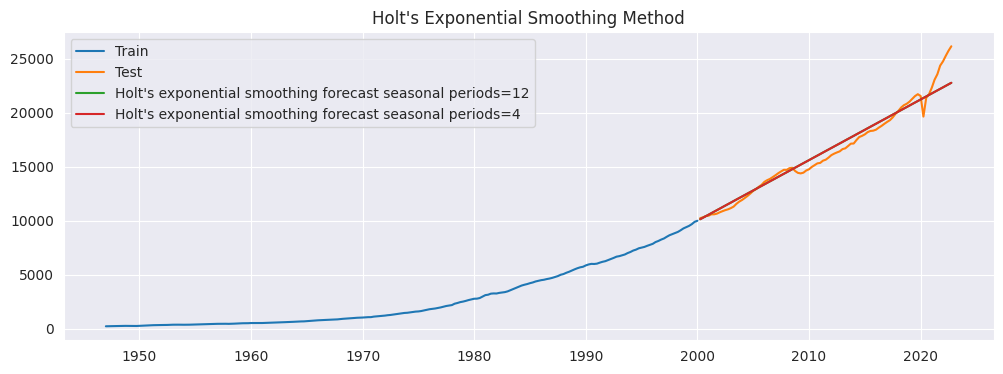

In [ ]:
plt.figure(figsize=(12,4))
plt.plot( train['Values'], label='Train')
plt.plot(test['Values'], label='Test')
plt.plot(y_hat_holt['holt_forecast'], label='Holt\'s exponential smoothing forecast seasonal periods=12')
plt.plot(y_hat_holt1['holt_forecast'], label='Holt\'s exponential smoothing forecast seasonal periods=4')
plt.legend(loc='best')
plt.title('Holt\'s Exponential Smoothing Method')
plt.show()

In [ ]:
rmse = np.sqrt(mean_squared_error(test['Values'], y_hat_holt['holt_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Values']-y_hat_holt['holt_forecast'])/test['Values'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt\'s exponential smoothing method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results


,Method,RMSE,MAPE
0,Naive method,7583.40,35.09
0,Simple average method,14186.32,81.79
0,Simple moving average forecast window size=4,7772.59,36.54
1,Simple moving average forecast window size=12,8247.11,40.12
0,Simple exponential smoothing forecast,7583.84,35.10
0,Holt's exponential smoothing method,840.29,3.25


# Holt Winter's Additive Forecast

In [ ]:
y_hat_hwa = test.copy()
model = ExponentialSmoothing(np.asarray(train['Values']) ,seasonal_periods=12 ,trend='add', seasonal='add')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwa['hw_forecast'] = model_fit.forecast(len(test))
y_hat_hwa

{'smoothing_level': 0.9925218730685065, 'smoothing_trend': 0.22315978851451315, 'smoothing_seasonal': 0.006859457985719383, 'damping_trend': nan, 'initial_level': 254.39742748848838, 'initial_trend': 3.323259869154868, 'initial_seasons': array([-3.7914122 , -6.80001255, -3.66776495, -0.70240169,  3.10638226,
        6.16573098,  6.57430222,  5.88550841, -4.50015553, -0.88141472,
       -1.23591744, -4.45243622]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


,Values,hw_forecast
2000-04-01,10247.720,10148.229092
2000-07-01,10318.165,10290.006204
2000-10-01,10435.744,10429.075979
2001-01-01,10470.231,10571.910990
2001-04-01,10599.000,10711.162200
...,...,...
2021-10-01,24349.121,22376.883017
2022-01-01,24740.480,22519.718027
2022-04-01,25248.476,22658.969237
2022-07-01,25723.941,22804.411470


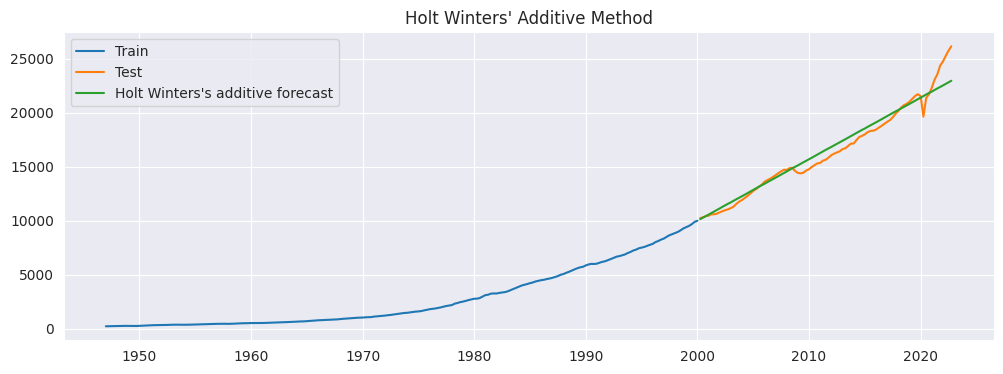

In [ ]:
plt.figure(figsize=(12,4))
plt.plot( train['Values'], label='Train')
plt.plot(test['Values'], label='Test')
plt.plot(y_hat_hwa['hw_forecast'], label='Holt Winters\'s additive forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Additive Method')
plt.show()

In [ ]:
rmse = np.sqrt(mean_squared_error(test['Values'], y_hat_hwa['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Values']-y_hat_hwa['hw_forecast'])/test['Values'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' additive method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results


,Method,RMSE,MAPE
0,Naive method,7583.40,35.09
0,Simple average method,14186.32,81.79
0,Simple moving average forecast window size=4,7772.59,36.54
1,Simple moving average forecast window size=12,8247.11,40.12
0,Simple exponential smoothing forecast,7583.84,35.10
0,Holt's exponential smoothing method,840.29,3.25
0,Holt Winters' additive method,834.49,3.40


# Holt Winter's Multiplicative Forecast

In [ ]:
y_hat_hwm = test.copy()
model = ExponentialSmoothing(np.asarray(train['Values']) ,seasonal_periods=12 ,trend='add', seasonal='mul')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwm['hw_forecast'] = model_fit.forecast(len(test))
y_hat_hwm

{'smoothing_level': 0.6767847091919118, 'smoothing_trend': 0.17655284820883474, 'smoothing_seasonal': 0.3232147926617173, 'damping_trend': nan, 'initial_level': 258.6820756204037, 'initial_trend': 5.619166818406364, 'initial_seasons': array([1.04454498, 1.03796765, 1.01334823, 1.00859677, 1.01799101,
       1.02409225, 1.04563588, 1.04982251, 1.02737223, 0.99089336,
       0.99021715, 1.00422688]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


,Values,hw_forecast
2000-04-01,10247.720,10172.575310
2000-07-01,10318.165,10311.368282
2000-10-01,10435.744,10431.605766
2001-01-01,10470.231,10546.612019
2001-04-01,10599.000,10666.363775
...,...,...
2021-10-01,24349.121,22110.677354
2022-01-01,24740.480,22199.133492
2022-04-01,25248.476,22298.199546
2022-07-01,25723.941,22469.368450


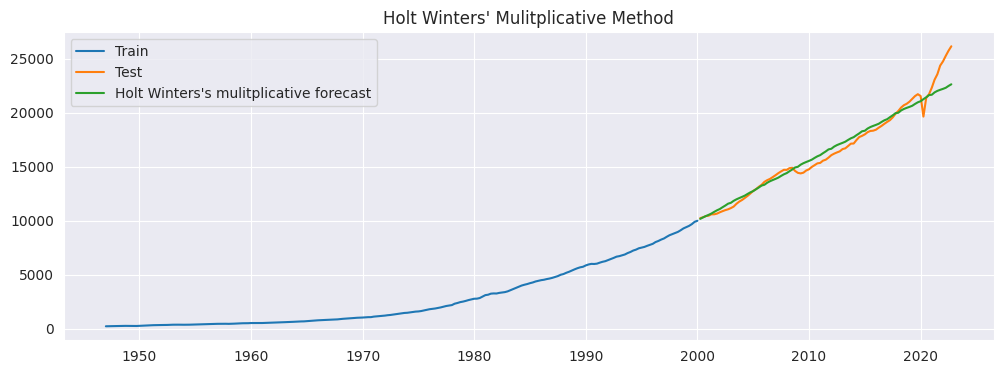

In [ ]:
plt.figure(figsize=(12,4))
plt.plot( train['Values'], label='Train')
plt.plot(test['Values'], label='Test')
plt.plot(y_hat_hwm['hw_forecast'], label='Holt Winters\'s mulitplicative forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Mulitplicative Method')
plt.show()


In [ ]:
rmse = np.sqrt(mean_squared_error(test['Values'], y_hat_hwm['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Values']-y_hat_hwm['hw_forecast'])/test['Values'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' multiplicative method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,7583.40,35.09
0,Simple average method,14186.32,81.79
0,Simple moving average forecast window size=4,7772.59,36.54
1,Simple moving average forecast window size=12,8247.11,40.12
0,Simple exponential smoothing forecast,7583.84,35.10
0,Holt's exponential smoothing method,840.29,3.25
0,Holt Winters' additive method,834.49,3.40
0,Holt Winters' multiplicative method,856.60,3.17


# ACF Test

In [ ]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(finaldata['Values'])

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' %adf_test[1])

ADF Statistic: 7.910249
Critical Values @ 0.05: -2.87
p-value: 1.000000


In [ ]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(finaldata['Values'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 2.612018
Critical Values @ 0.05: 0.46
p-value: 0.010000


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


# Making the series Stationary

In [ ]:
from scipy.stats import boxcox
data_boxcox = pd.DataFrame(boxcox(finaldata['Values'], lmbda=0), index = finaldata.index)



In [ ]:
data_boxcox

,0
1947-01-01,5.493736
1947-04-01,5.505201
1947-07-01,5.519800
1947-10-01,5.559700
1948-01-01,5.582526
...,...
2021-10-01,10.100251
2022-01-01,10.116196
2022-04-01,10.136521
2022-07-01,10.155177


In [ ]:
data_boxcox.columns=['Values']
data_boxcox

,Values
1947-01-01,5.493736
1947-04-01,5.505201
1947-07-01,5.519800
1947-10-01,5.559700
1948-01-01,5.582526
...,...
2021-10-01,10.100251
2022-01-01,10.116196
2022-04-01,10.136521
2022-07-01,10.155177


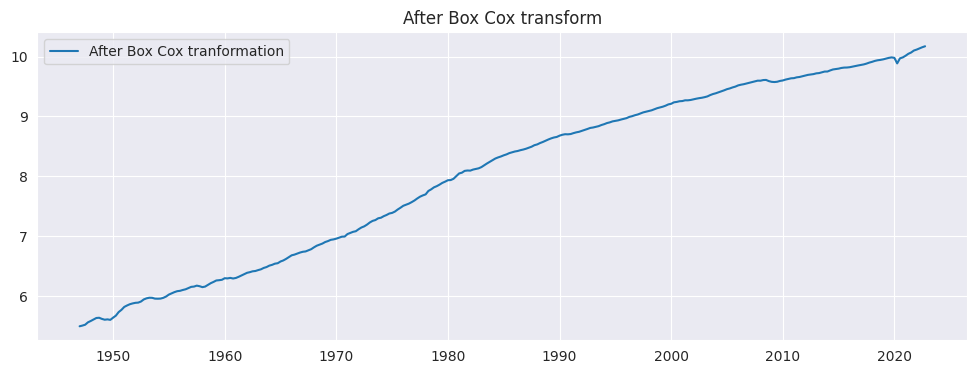

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(data_boxcox.Values, label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

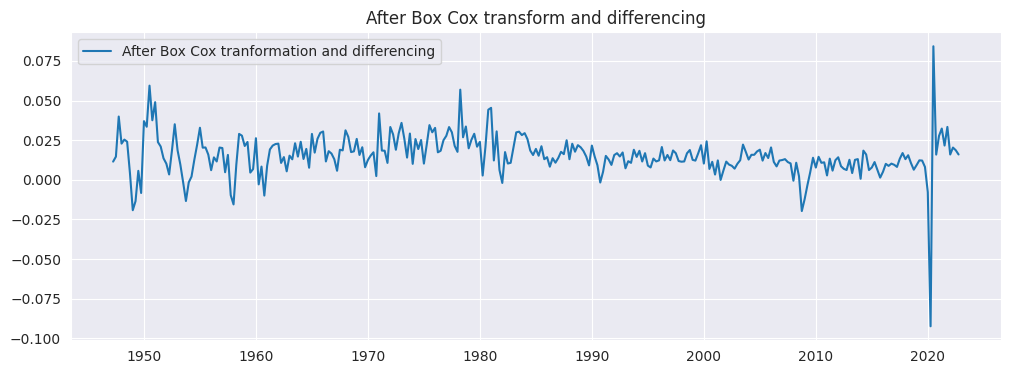

In [ ]:
data_boxcox_diff = pd.DataFrame(data_boxcox - data_boxcox.shift(), finaldata.index)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox tranformation and differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

In [ ]:
data_boxcox_diff.columns=['Values']
data_boxcox_diff.head()

,Values
1947-01-01,NaN
1947-04-01,0.011465
1947-07-01,0.014598
1947-10-01,0.039901
1948-01-01,0.022826


In [ ]:
data_boxcox_diff.dropna(inplace=True)
data_boxcox_diff

,Values
1947-04-01,0.011465
1947-07-01,0.014598
1947-10-01,0.039901
1948-01-01,0.022826
1948-04-01,0.025359
...,...
2021-10-01,0.033352
2022-01-01,0.015945
2022-04-01,0.020325
2022-07-01,0.018656


In [ ]:
adf_test = adfuller(data_boxcox_diff.Values)

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -8.545175
Critical Values @ 0.05: -2.87
p-value: 0.000000


In [ ]:
kpss_test = kpss(data_boxcox_diff.Values)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.851558
Critical Values @ 0.05: 0.46
p-value: 0.010000


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


# ARIMA Models

In [ ]:

from statsmodels.tsa.arima_model import ARIMA


In [ ]:
train_data_boxcox = data_boxcox.Values[:train_len]
test_data_boxcox = data_boxcox.Values[train_len:]
train_data_boxcox_diff = data_boxcox_diff.Values[:train_len-1]
test_data_boxcox_diff = data_boxcox_diff.Values[train_len-1:]

In [ ]:
import statsmodels.api as sm

In [ ]:
model = sm.tsa.arima.ARIMA(train_data_boxcox_diff, order=(1,0,0))
model_fit = model.fit()
print(model_fit.params)



const     0.017482
ar.L1     0.442901
sigma2    0.000104
dtype: float64


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


## Auto Regressive (AR)

In [ ]:
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox.Values[0])
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])
y_hat_ar

,Values,ar_forecast_boxcox_diff,ar_forecast_boxcox,ar_forecast
1947-04-01,0.011465,0.017482,5.511218,247.452401
1947-07-01,0.014598,0.014817,5.526036,251.146274
1947-10-01,0.039901,0.016205,5.542240,255.249200
1948-01-01,0.022826,0.027411,5.569652,262.342713
1948-04-01,0.025359,0.019849,5.589500,267.601903
...,...,...,...,...
2021-10-01,0.033352,0.017482,10.723047,45389.980615
2022-01-01,0.015945,0.017482,10.740529,46190.470990
2022-04-01,0.020325,0.017482,10.758011,47005.078684
2022-07-01,0.018656,0.017482,10.775493,47834.052668


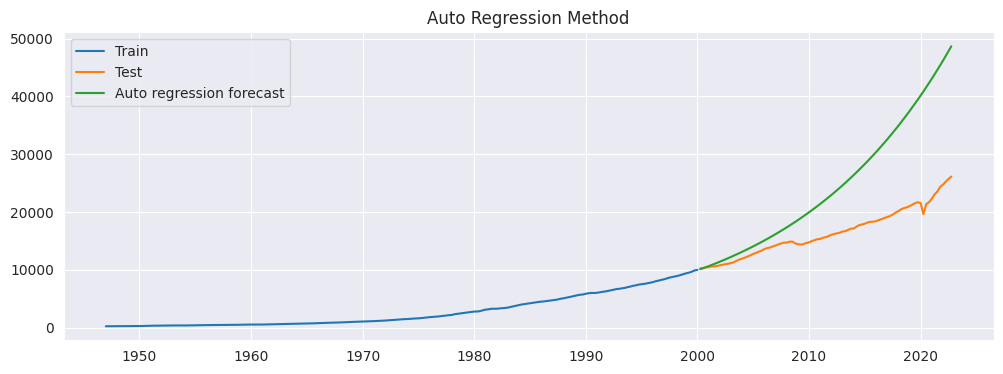

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(train['Values'], label='Train')
plt.plot(test['Values'], label='Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label='Auto regression forecast')
plt.legend(loc='best')
plt.title('Auto Regression Method')
plt.show()

In [ ]:
print(test.index.min())
y_hat_ar['ar_forecast'][test.index.min():]

2000-04-01 00:00:00


2000-04-01    10118.588398
2000-07-01    10282.442836
2000-10-01    10457.210773
2001-01-01    10638.671916
2001-04-01    10824.959737
                  ...     
2021-10-01    45389.980615
2022-01-01    46190.470990
2022-04-01    47005.078684
2022-07-01    47834.052668
2022-10-01    48677.646303
Name: ar_forecast, Length: 91, dtype: float64

In [ ]:
rmse = np.sqrt(mean_squared_error(test['Values'], y_hat_ar['ar_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Values']-y_hat_ar['ar_forecast'][test.index.min():])/test['Values'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive (AR) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,7583.40,35.09
0,Simple average method,14186.32,81.79
0,Simple moving average forecast window size=4,7772.59,36.54
1,Simple moving average forecast window size=12,8247.11,40.12
0,Simple exponential smoothing forecast,7583.84,35.10
0,Holt's exponential smoothing method,840.29,3.25
0,Holt Winters' additive method,834.49,3.40
0,Holt Winters' multiplicative method,856.60,3.17
0,Autoregressive (AR) method,10800.80,42.73


## Moving Average(MA)


In [ ]:
model = sm.tsa.arima.ARIMA(train_data_boxcox_diff, order=(0,0,1))
model_fit = model.fit()
print(model_fit.params)

const     0.017510
ma.L1     0.305350
sigma2    0.000111
dtype: float64


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [ ]:
y_hat_ma = data_boxcox_diff.copy()
y_hat_ma['ma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox_diff'].cumsum()
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox'].add(data_boxcox.Values[0])
y_hat_ma['ma_forecast'] = np.exp(y_hat_ma['ma_forecast_boxcox'])
y_hat_ma

,Values,ma_forecast_boxcox_diff,ma_forecast_boxcox,ma_forecast
1947-04-01,0.011465,0.017510,5.511246,247.459372
1947-07-01,0.014598,0.015822,5.527068,251.405786
1947-10-01,0.039901,0.017140,5.544208,255.751910
1948-01-01,0.022826,0.024455,5.568663,262.083515
1948-04-01,0.025359,0.017013,5.585676,266.580401
...,...,...,...,...
2021-10-01,0.033352,0.017510,10.729910,45702.601215
2022-01-01,0.015945,0.017510,10.747421,46509.915095
2022-04-01,0.020325,0.017510,10.764931,47331.489776
2022-07-01,0.018656,0.017510,10.782441,48167.577167


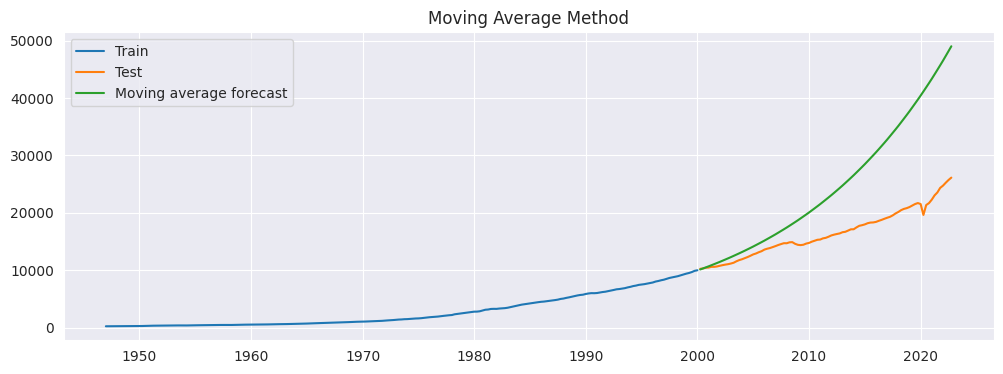

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(finaldata['Values'][:train_len], label='Train')
plt.plot(finaldata['Values'][train_len:], label='Test')
plt.plot(y_hat_ma['ma_forecast'][test.index.min():], label='Moving average forecast')
plt.legend(loc='best')
plt.title('Moving Average Method')
plt.show()

In [ ]:
rmse = np.sqrt(mean_squared_error(test['Values'], y_hat_ma['ma_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Values']-y_hat_ma['ma_forecast'][test.index.min():])/test['Values'])*100,2)

tempResults = pd.DataFrame({'Method':['Moving Average (MA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,7583.40,35.09
0,Simple average method,14186.32,81.79
0,Simple moving average forecast window size=4,7772.59,36.54
1,Simple moving average forecast window size=12,8247.11,40.12
0,Simple exponential smoothing forecast,7583.84,35.10
0,Holt's exponential smoothing method,840.29,3.25
0,Holt Winters' additive method,834.49,3.40
0,Holt Winters' multiplicative method,856.60,3.17
0,Autoregressive (AR) method,10800.80,42.73
0,Moving Average (MA) method,10968.39,43.55


## Auto Regressive Moving Average(ARMA)

In [ ]:
model = sm.tsa.arima.ARIMA(train_data_boxcox_diff, order=(1,0,1))
model_fit = model.fit()
print(model_fit.params)

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


const     0.017467
ar.L1     0.584305
ma.L1    -0.168584
sigma2    0.000103
dtype: float64


In [ ]:
y_hat_arma = data_boxcox_diff.copy()
y_hat_arma['arma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox_diff'].cumsum()
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox'].add(data_boxcox.Values[0])
y_hat_arma['arma_forecast'] = np.exp(y_hat_arma['arma_forecast_boxcox'])

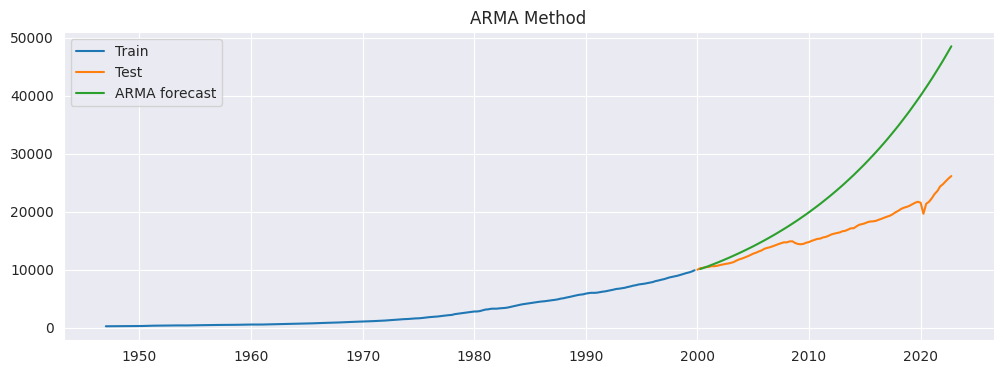

In [ ]:
plt.figure(figsize=(12,4))
plt.plot( finaldata['Values'][:train_len-1], label='Train')
plt.plot(finaldata['Values'][train_len-1:], label='Test')
plt.plot(y_hat_arma['arma_forecast'][test.index.min():], label='ARMA forecast')
plt.legend(loc='best')
plt.title('ARMA Method')
plt.show()


In [ ]:
rmse = np.sqrt(mean_squared_error(test['Values'], y_hat_arma['arma_forecast'][train_len-1:])).round(2)
mape = np.round(np.mean(np.abs(test['Values']-y_hat_arma['arma_forecast'][train_len-1:])/test['Values'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive moving average (ARMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,7583.40,35.09
0,Simple average method,14186.32,81.79
0,Simple moving average forecast window size=4,7772.59,36.54
1,Simple moving average forecast window size=12,8247.11,40.12
0,Simple exponential smoothing forecast,7583.84,35.10
0,Holt's exponential smoothing method,840.29,3.25
0,Holt Winters' additive method,834.49,3.40
0,Holt Winters' multiplicative method,856.60,3.17
0,Autoregressive (AR) method,10800.80,42.73
0,Moving Average (MA) method,10968.39,43.55


## Auto Regressive Integrated Moving Average(ARIMA)

In [ ]:
model = sm.tsa.arima.ARIMA(train_data_boxcox_diff, order=(1,1,1))
model_fit = model.fit()
print(model_fit.params)

ar.L1    -0.311117
ma.L1    -0.070976
sigma2    0.000124
dtype: float64


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [ ]:
y_hat_arima = data_boxcox_diff.copy()
y_hat_arima['arima_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox_diff'].cumsum()
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox'].add(data_boxcox.Values[0])
y_hat_arima['arima_forecast'] = np.exp(y_hat_arima['arima_forecast_boxcox'])
y_hat_arima

,Values,arima_forecast_boxcox_diff,arima_forecast_boxcox,arima_forecast
1947-04-01,0.011465,0.000000,5.493736,243.164000
1947-07-01,0.014598,0.011465,5.505201,245.968000
1947-10-01,0.039901,0.013432,5.518633,249.294138
1948-01-01,0.022826,0.030151,5.548785,256.925172
1948-04-01,0.025359,0.028658,5.577443,264.394627
...,...,...,...,...
2021-10-01,0.033352,0.013506,10.372053,31954.025533
2022-01-01,0.015945,0.013506,10.385560,32388.528476
2022-04-01,0.020325,0.013506,10.399066,32828.939684
2022-07-01,0.018656,0.013506,10.412572,33275.339494


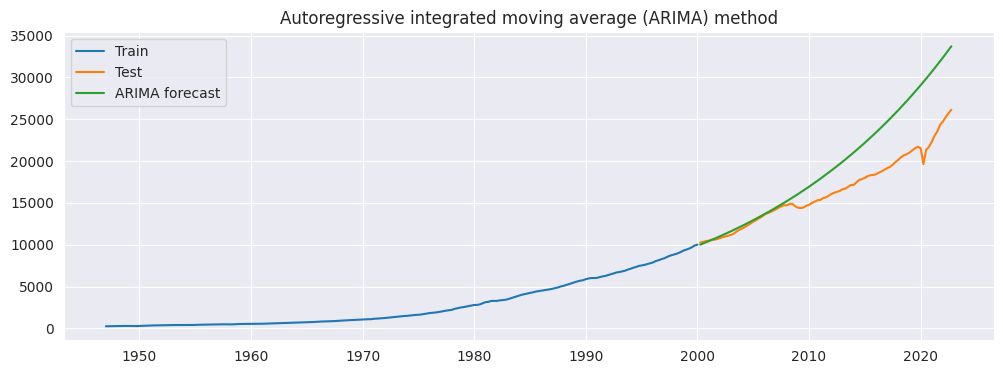

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(train['Values'], label='Train')
plt.plot(test['Values'], label='Test')
plt.plot(y_hat_arima['arima_forecast'][test.index.min():], label='ARIMA forecast')
plt.legend(loc='best')
plt.title('Autoregressive integrated moving average (ARIMA) method')
plt.show()

In [ ]:
rmse = np.sqrt(mean_squared_error(test['Values'], y_hat_arima['arima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Values']-y_hat_arima['arima_forecast'][test.index.min():])/test['Values'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive integrated moving average (ARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,7583.40,35.09
0,Simple average method,14186.32,81.79
0,Simple moving average forecast window size=4,7772.59,36.54
1,Simple moving average forecast window size=12,8247.11,40.12
0,Simple exponential smoothing forecast,7583.84,35.10
0,Holt's exponential smoothing method,840.29,3.25
0,Holt Winters' additive method,834.49,3.40
0,Holt Winters' multiplicative method,856.60,3.17
0,Autoregressive (AR) method,10800.80,42.73
0,Moving Average (MA) method,10968.39,43.55


## Seasonal Auto Regressive Integrated Moving Average

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data_boxcox, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)) 
model_fit = model.fit()
print(model_fit.params)

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


ar.L1       0.578305
ma.L1      -0.128335
ar.S.L12   -0.135516
ma.S.L12   -0.877124
sigma2      0.000110
dtype: float64


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
y_hat_sarima = data_boxcox_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])
y_hat_sarima

,Values,sarima_forecast_boxcox,sarima_forecast
1947-04-01,0.011465,5.493736,243.164000
1947-07-01,0.014598,5.505201,245.968000
1947-10-01,0.039901,5.519800,249.585000
1948-01-01,0.022826,5.559700,259.745000
1948-04-01,0.025359,5.582526,265.742000
...,...,...,...
2021-10-01,0.033352,10.699031,44312.887436
2022-01-01,0.015945,10.718000,45161.488504
2022-04-01,0.020325,10.734554,45915.320907
2022-07-01,0.018656,10.752709,46756.527341


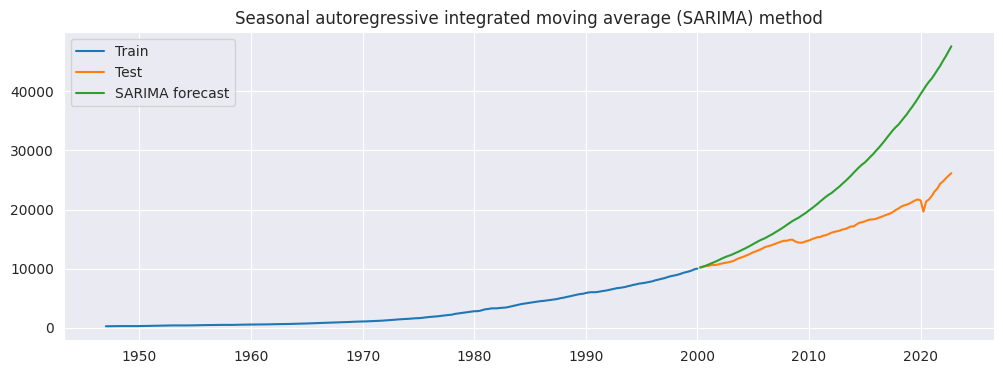

In [ ]:

plt.figure(figsize=(12,4))
plt.plot(train['Values'], label='Train')
plt.plot(test['Values'], label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test.index.min():], label='SARIMA forecast')
plt.legend(loc='best')
plt.title('Seasonal autoregressive integrated moving average (SARIMA) method')
plt.show()

In [ ]:
rmse = np.sqrt(mean_squared_error(test['Values'], y_hat_sarima['sarima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Values']-y_hat_sarima['sarima_forecast'][test.index.min():])/test['Values'])*100,2)

tempResults = pd.DataFrame({'Method':['Seasonal autoregressive integrated moving average (SARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,7583.40,35.09
0,Simple average method,14186.32,81.79
0,Simple moving average forecast window size=4,7772.59,36.54
1,Simple moving average forecast window size=12,8247.11,40.12
0,Simple exponential smoothing forecast,7583.84,35.10
0,Holt's exponential smoothing method,840.29,3.25
0,Holt Winters' additive method,834.49,3.40
0,Holt Winters' multiplicative method,856.60,3.17
0,Autoregressive (AR) method,10800.80,42.73
0,Moving Average (MA) method,10968.39,43.55


In [ ]:
minvalue_series1 = results.MAPE.min()
minvalue_series2=results.RMSE.min()

In [ ]:
print(f"The following are the best forecasting methods for the give data, with score of:{results[results.MAPE==minvalue_series1]['Method'],minvalue_series1}")
print(results[results.RMSE==minvalue_series2]['Method'],minvalue_series2)

The following are the best forecasting methods for the give data, with score of:(0    Holt Winters' multiplicative method
Name: Method, dtype: object, 3.17)
0    Holt Winters' additive method
Name: Method, dtype: object 834.49


# RNN Methods

## Vanilla RNN

### Series Split

In [ ]:
finaldata_vanilla=finaldata.copy()
finaldata_vanilla

,Values
1947-01-01,243.164
1947-04-01,245.968
1947-07-01,249.585
1947-10-01,259.745
1948-01-01,265.742
...,...
2021-10-01,24349.121
2022-01-01,24740.480
2022-04-01,25248.476
2022-07-01,25723.941


In [ ]:

# Split the data into training and testing sets
train_size1 = int(len(finaldata_vanilla) * 0.7)
train_data1, test_data1 = finaldata_vanilla[:train_size1], finaldata_vanilla[train_size1:]

### Scaling using MinMax Scaler

In [ ]:
# Scale the data using MinMaxScaler
scaler = MinMaxScaler()
train_scaled1 = scaler.fit_transform(train_data1)
test_scaled1 = scaler.transform(test_data1)

### Generate Training and Testing set

In [ ]:
# Define the lookback window size
lookback = 12

# Create the training and testing datasets
def create_dataset(data, lookback):
    X, Y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:(i + lookback)])
        Y.append(data[i + lookback])
    return np.array(X), np.array(Y)

train_X1, train_Y1 = create_dataset(train_scaled1, lookback)
test_X1, test_Y1 = create_dataset(test_scaled1, lookback)

### Model Compiling and Fitting

In [ ]:
# Define the model
early_stopping = EarlyStopping(monitor='loss', patience=3)
model = Sequential()
model.add(SimpleRNN(64, input_shape=(train_X1.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
# Fit the model to the training data
model.fit(train_X1, train_Y1, epochs=100, batch_size=32, verbose=1,callbacks=[early_stopping])


Epoch 1/100
7/7 [==============================] - 2s 6ms/step - loss: 0.0111
Epoch 2/100
7/7 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 3/100
7/7 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 4/100
7/7 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 5/100
7/7 [==============================] - 0s 6ms/step - loss: 7.1299e-04
Epoch 6/100
7/7 [==============================] - 0s 6ms/step - loss: 4.3898e-04
Epoch 7/100
7/7 [==============================] - 0s 5ms/step - loss: 3.6824e-04
Epoch 8/100
7/7 [==============================] - 0s 5ms/step - loss: 2.1552e-04
Epoch 9/100
7/7 [==============================] - 0s 5ms/step - loss: 1.7003e-04
Epoch 10/100
7/7 [==============================] - 0s 5ms/step - loss: 1.4069e-04
Epoch 11/100
7/7 [==============================] - 0s 5ms/step - loss: 1.2255e-04
Epoch 12/100
7/7 [==============================] - 0s 7ms/step - loss: 9.7817e-05
Epoch 13/100
7/7 [===========

### Making Predictions

In [ ]:
# Generate the predicted values for the training and testing data
train_predictions1 = model.predict(train_X1)
test_predictions1 = model.predict(test_X1)

3/3 [==============================] - 0s 4ms/step


In [ ]:
# Inverse scale the predicted and actual values
train_predictions1 = scaler.inverse_transform(train_predictions1)
train_actuals1 = scaler.inverse_transform(train_Y1.reshape(-1, 1))
test_predictions1 = scaler.inverse_transform(test_predictions1)
test_actuals1 = scaler.inverse_transform(test_Y1.reshape(-1, 1))

### Plotting the Results

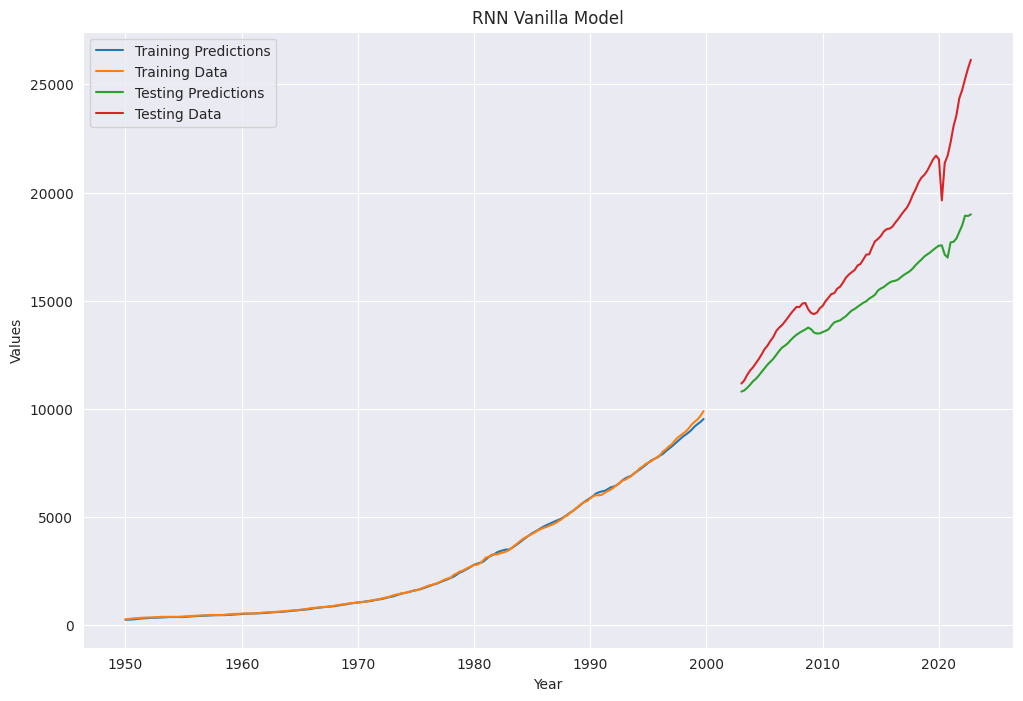

In [ ]:
# Plot the predicted and actual values for training and testing data
plt.plot(train_data1.index[lookback:], train_predictions1, label='Training Predictions')
plt.plot(train_data1.index[lookback:], train_actuals1, label='Training Data')
plt.plot(test_data1.index[lookback:], test_predictions1, label='Testing Predictions')
plt.plot(test_data1.index[lookback:], test_actuals1, label='Testing Data')

# Add title, x and y axis labels and legend to the plot
plt.title('RNN Vanilla Model')
plt.xlabel('Year')
plt.ylabel('Values')
plt.legend()
plt.show()

In [ ]:
test_mape_van = np.mean(np.abs((test_actuals1 - test_predictions1) / test_actuals1)) *100
test_rmse = np.sqrt(mean_squared_error(test_actuals1, test_predictions1))
tempResults = pd.DataFrame({'Method':['Vanilla RNN'], 'RMSE':[test_rmse] ,'MAPE': [test_mape_van] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,7583.400000,35.090000
0,Simple average method,14186.320000,81.790000
0,Simple moving average forecast window size=4,7772.590000,36.540000
1,Simple moving average forecast window size=12,8247.110000,40.120000
0,Simple exponential smoothing forecast,7583.840000,35.100000
0,Holt's exponential smoothing method,840.290000,3.250000
0,Holt Winters' additive method,834.490000,3.400000
0,Holt Winters' multiplicative method,856.600000,3.170000
0,Autoregressive (AR) method,10800.800000,42.730000
0,Moving Average (MA) method,10968.390000,43.550000


## GRU RNN

### Series Split

In [ ]:
finaldata_gru=finaldata.copy()
finaldata_gru

,Values
1947-01-01,243.164
1947-04-01,245.968
1947-07-01,249.585
1947-10-01,259.745
1948-01-01,265.742
...,...
2021-10-01,24349.121
2022-01-01,24740.480
2022-04-01,25248.476
2022-07-01,25723.941


In [ ]:
# Split the data into training and testing sets
train_size2 = int(len(finaldata_gru) * 0.7)
train_data2 = finaldata_gru[:train_size2]
test_data2 = finaldata_gru[train_size2:]

### Scaling using MinMax Scaler

In [ ]:
# Scale the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled2 = scaler.fit_transform(train_data2)
test_data_scaled2 = scaler.transform(test_data2)

### Generating Training and Testing set

In [ ]:
def generate_data(data, lookback):
    X, Y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback, 0])
        Y.append(data[i + lookback, 0])
    return np.array(X), np.array(Y)

# Generate the training and testing data with a lookback window of 12
lookback = 12
train_X2, train_Y2 = generate_data(train_data_scaled2, lookback)
test_X2, test_Y2 = generate_data(test_data_scaled2, lookback)

### Model Compiling and Fitting

In [ ]:
# Build the GRU model
early_stopping = EarlyStopping(monitor='loss', patience=3)
model = Sequential()
model.add(GRU(units=50, input_shape=(lookback, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
# Train the model
history = model.fit(train_X2, train_Y2, epochs=100, batch_size=32, validation_data=(test_X2, test_Y2), verbose=1,callbacks=[early_stopping])

Epoch 1/100
7/7 [==============================] - 3s 108ms/step - loss: 0.1750 - val_loss: 2.7687
Epoch 2/100
7/7 [==============================] - 0s 17ms/step - loss: 0.0795 - val_loss: 1.4585
Epoch 3/100
7/7 [==============================] - 0s 16ms/step - loss: 0.0388 - val_loss: 0.6618
Epoch 4/100
7/7 [==============================] - 0s 18ms/step - loss: 0.0308 - val_loss: 0.3233
Epoch 5/100
7/7 [==============================] - 0s 16ms/step - loss: 0.0218 - val_loss: 0.2395
Epoch 6/100
7/7 [==============================] - 0s 17ms/step - loss: 0.0110 - val_loss: 0.1857
Epoch 7/100
7/7 [==============================] - 0s 19ms/step - loss: 0.0051 - val_loss: 0.0732
Epoch 8/100
7/7 [==============================] - 0s 16ms/step - loss: 0.0013 - val_loss: 0.0070
Epoch 9/100
7/7 [==============================] - 0s 19ms/step - loss: 2.2752e-04 - val_loss: 0.0157
Epoch 10/100
7/7 [==============================] - 0s 15ms/step - loss: 3.8398e-04 - val_loss: 0.0102
Epoch 11/1

In [ ]:
# Evaluate the model on the testing data
test_loss2 = model.evaluate(test_X2, test_Y2)
print('Test Loss:', test_loss2)

3/3 [==============================] - 0s 11ms/step - loss: 0.0219
Test Loss: 0.021865542978048325


### Making Predictions

In [ ]:
# Generate the predicted values for the training and testing data
train_predictions2 = model.predict(train_X2)
test_predictions2 = model.predict(test_X2)

3/3 [==============================] - 0s 13ms/step


In [ ]:
# Inverse scale the predicted and actual values
train_predictions2 = scaler.inverse_transform(train_predictions2)
train_actuals2 = scaler.inverse_transform(train_Y2.reshape(-1, 1))
test_predictions2 = scaler.inverse_transform(test_predictions2)
test_actuals2 = scaler.inverse_transform(test_Y2.reshape(-1, 1))

### Plotting the Results

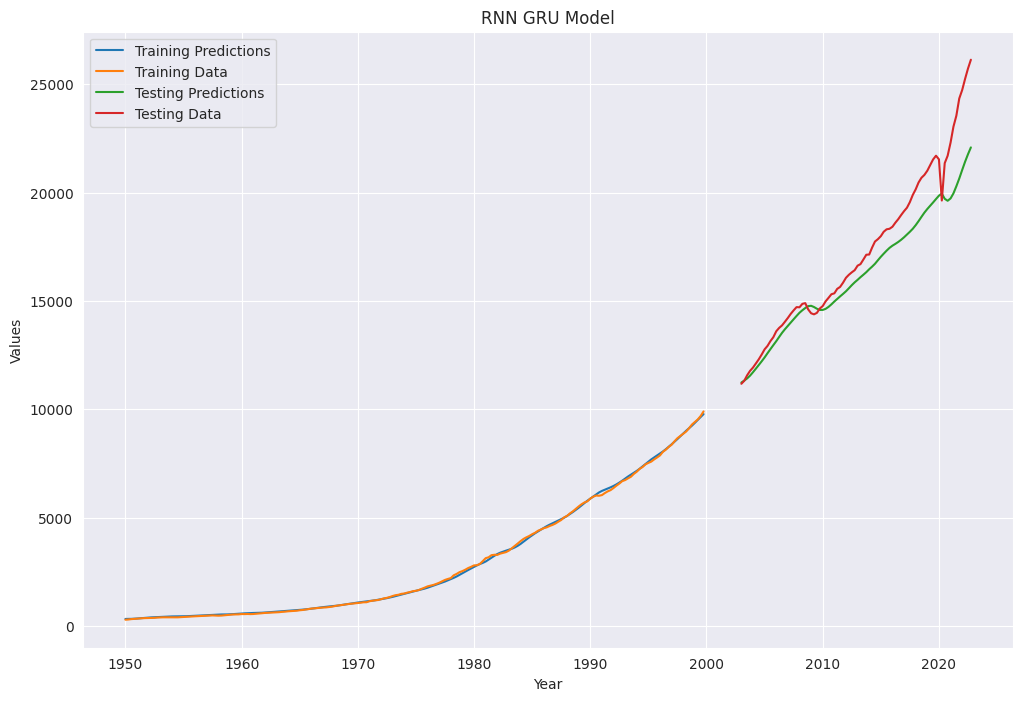

In [ ]:
# Plot the predicted and actual values for training and testing data
plt.plot(train_data2.index[lookback:], train_predictions2, label='Training Predictions')
plt.plot(train_data2.index[lookback:], train_actuals2, label='Training Data')
plt.plot(test_data2.index[lookback:], test_predictions2, label='Testing Predictions')
plt.plot(test_data2.index[lookback:], test_actuals2, label='Testing Data')

# Add title, x and y axis labels and legend to the plot
plt.title('RNN GRU Model')
plt.xlabel('Year')
plt.ylabel('Values')
plt.legend()
plt.show()

In [ ]:
test_mape_gru = np.mean(np.abs((test_actuals2 - test_predictions2) / test_actuals2)) *100
test_rmse_gru = np.sqrt(mean_squared_error(test_actuals2, test_predictions2))
tempResults = pd.DataFrame({'Method':['GRU RNN'], 'RMSE':[test_rmse_gru] ,'MAPE': [test_mape_gru] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,7583.400000,35.090000
0,Simple average method,14186.320000,81.790000
0,Simple moving average forecast window size=4,7772.590000,36.540000
1,Simple moving average forecast window size=12,8247.110000,40.120000
0,Simple exponential smoothing forecast,7583.840000,35.100000
0,Holt's exponential smoothing method,840.290000,3.250000
0,Holt Winters' additive method,834.490000,3.400000
0,Holt Winters' multiplicative method,856.600000,3.170000
0,Autoregressive (AR) method,10800.800000,42.730000
0,Moving Average (MA) method,10968.390000,43.550000


## LSTM

### Scaling using MinMax Scaler

In [ ]:
finaldata_lstm=finaldata.copy()
finaldata_lstm

,Values
1947-01-01,243.164
1947-04-01,245.968
1947-07-01,249.585
1947-10-01,259.745
1948-01-01,265.742
...,...
2021-10-01,24349.121
2022-01-01,24740.480
2022-04-01,25248.476
2022-07-01,25723.941


In [ ]:
# Scale the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data3 = scaler.fit_transform(finaldata_lstm.values.reshape(-1, 1))

## Series Split

In [ ]:
# Split the data into training and testing sets
train_size3 = int(len(scaled_data3) * 0.7)
train_data3 = scaled_data3[:train_size3]
test_data3 = scaled_data3[train_size3:]

### Generating Training and Test set

In [ ]:
# Generate the training and testing data 
X_train3, y_train3 = train_data3[:-1], train_data3[1:]
X_test3, y_test3 = test_data3[:-1], test_data3[1:]
X_train3 = X_train3.reshape((X_train3.shape[0], 1, X_train3.shape[1]))
X_test3 = X_test3.reshape((X_test3.shape[0], 1, X_test3.shape[1]))

### Model Compiling and Fitting

In [ ]:
# Build the LSTM model
early_stopping = EarlyStopping(monitor='loss', patience=3)
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(1, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
# Train the model
model.fit(X_train3, y_train3, epochs=100, batch_size=1, verbose=1,callbacks=[early_stopping])

Epoch 1/100
211/211 [==============================] - 4s 6ms/step - loss: 0.0108
Epoch 2/100
211/211 [==============================] - 2s 10ms/step - loss: 0.0075
Epoch 3/100
211/211 [==============================] - 1s 5ms/step - loss: 0.0052
Epoch 4/100
211/211 [==============================] - 1s 5ms/step - loss: 0.0027
Epoch 5/100
211/211 [==============================] - 1s 6ms/step - loss: 9.4970e-04
Epoch 6/100
211/211 [==============================] - 1s 6ms/step - loss: 1.8372e-04
Epoch 7/100
211/211 [==============================] - 2s 8ms/step - loss: 3.2365e-05
Epoch 8/100
211/211 [==============================] - 2s 9ms/step - loss: 1.7274e-05
Epoch 9/100
211/211 [==============================] - 2s 9ms/step - loss: 1.6461e-05
Epoch 10/100
211/211 [==============================] - 1s 5ms/step - loss: 1.6255e-05
Epoch 11/100
211/211 [==============================] - 1s 4ms/step - loss: 1.6418e-05
Epoch 12/100
211/211 [==============================] - 2s 8ms/step

### Making Predictions

In [ ]:
# Evaluate the model on the testing data
y_pred_train3 = model.predict(X_train3)
y_pred_test3 = model.predict(X_test3)

3/3 [==============================] - 0s 4ms/step


In [ ]:
# Inverse scale the predicted and actual values
y_train_inv3 = scaler.inverse_transform(y_train3)
y_pred_train_inv3 = scaler.inverse_transform(y_pred_train3)
y_test_inv3 = scaler.inverse_transform(y_test3[1:])
y_pred_test_inv3 = scaler.inverse_transform(y_pred_test3)

### Plotting the Results

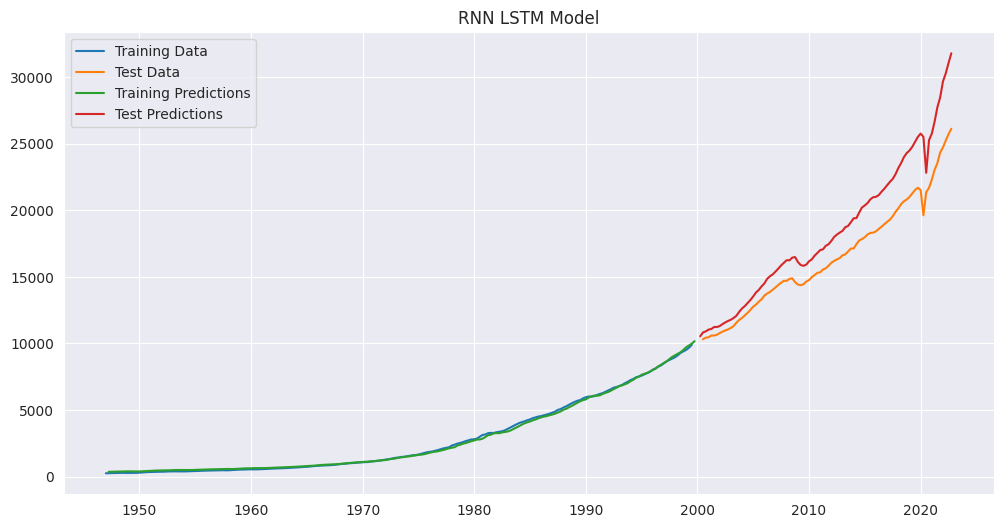

In [ ]:
# Plot the predicted and actual values for training and testing data
plt.figure(figsize=(12, 6))
plt.plot(finaldata_lstm.index[:train_size3-1], y_train_inv3, label='Training Data')
plt.plot(finaldata_lstm.index[train_size3+2:], y_test_inv3, label='Test Data')
plt.plot(finaldata_lstm.index[1:train_size3], y_pred_train_inv3, label='Training Predictions')
plt.plot(finaldata_lstm.index[train_size3+1:], y_pred_test_inv3, label='Test Predictions')
plt.title('RNN LSTM Model')
plt.legend()
plt.show()

In [ ]:
y_train_inv4 = scaler.inverse_transform(y_train3)
y_pred_train_inv4 = scaler.inverse_transform(y_pred_train3)
y_test_inv4 = scaler.inverse_transform(y_test3[1:])
y_pred_test_inv4 = scaler.inverse_transform(y_pred_test3[1:])

In [ ]:
test_rmse_lstm = np.sqrt(mean_squared_error(y_test_inv4, y_pred_test_inv4))
test_mape_lstm = np.mean(np.abs((y_test_inv4 - y_pred_test_inv4) / y_test_inv4)) * 100
tempResults = pd.DataFrame({'Method':['LSTM RNN'], 'RMSE':[test_rmse_lstm] ,'MAPE': [test_mape_lstm] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,7583.400000,35.090000
0,Simple average method,14186.320000,81.790000
0,Simple moving average forecast window size=4,7772.590000,36.540000
1,Simple moving average forecast window size=12,8247.110000,40.120000
0,Simple exponential smoothing forecast,7583.840000,35.100000
0,Holt's exponential smoothing method,840.290000,3.250000
0,Holt Winters' additive method,834.490000,3.400000
0,Holt Winters' multiplicative method,856.600000,3.170000
0,Autoregressive (AR) method,10800.800000,42.730000
0,Moving Average (MA) method,10968.390000,43.550000
